<a href="https://colab.research.google.com/github/JakubBrojacz/Poem-Generation/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview

The whole thing will not produce meaningful results.
Training time is too low with too high number of different words to teach encoder-decoder model
We need either pretrained model or ability to run it over many hours (colab unfortunetely restarts every 2 hours)

Premature optimization is the root of all evil - this code is not user friendly and is not compliant with good programming practices. It's only to check dataset and some basic ideas or solutions to the problem.

Unfortunetely some of data analysis code was lost by colab crashing, so not all plots can be generated from existing code.

In [ ]:
# 1. Add kaggle.json file with credentials to Colab
! ls
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d michaelarman/poemsdataset
! unzip -q poemsdataset.zip

# Don't look at warnings, we can skip some categories

In [ ]:
! pip install pronouncing

In [4]:
import torch
import pathlib
import unicodedata
import re
import pandas as pd
import numpy as np
import pronouncing
import collections
import matplotlib
%matplotlib inline  
import matplotlib.pyplot as plt  # noqa
# from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM, BertForSequenceClassification

In [5]:
%matplotlib inline

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import itertools

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)

cpu
1.10.0+cu111


In [6]:


MAX_LENGTH = 10

def filterPair(p):
    return len(p[0].split()) < MAX_LENGTH and \
        len(p[1].split()) < MAX_LENGTH


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [7]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z]+", r" ", s)
    s = s.lower()
    return s

In [8]:
DATA_PATH = pathlib.Path('/content/forms')

In [ ]:
dataset = []
for dirname in DATA_PATH.iterdir():
  # if 'abc' not in dirname.name:
  #     continue
  for file_name in (DATA_PATH/dirname).iterdir():
      line0 = ''
      with open(file_name) as f:
          for line in f:
              line = normalizeString(line)
              if line0 == '':
                  line0=line
                  continue
              dataset.append([line0, line])
              line0=''
dataset = filterPairs(dataset)
print(f'Len of dataset: {len(dataset)}')


In [ ]:
# for dirname in DATA_PATH.iterdir():
#   num_of_words = 0
#   num_of_lines = 0
#   num_of_aa_rhymes = 0
#   num_of_files = 0
#   for file_name in (DATA_PATH/dirname).iterdir():
#     num_of_files +=1
#     with open(file_name) as f:
#       for line1,line2 in itertools.zip_longest(*[f]*2):
#         if not line2:
#           continue
#         line1 = normalizeString(line1)
#         line2 = normalizeString(line2)
#         if not (line1.split() and line2.split()):
#           continue
#         num_of_words += len(line1.split()) + len(line2.split())
#         num_of_lines += 2
#         num_of_aa_rhymes += line1.split()[-1] in pronouncing.rhymes(line2.split()[-1])
#   if num_of_aa_rhymes < num_of_lines/8:
#     continue
#   print(dirname)
#   print(f'words: {num_of_words}')
#   print(f'lines: {num_of_lines}')
#   print(f'aa rhymes: {num_of_aa_rhymes}')
#   print(f'files: {num_of_files}')

word_counts = collections.Counter()
line_lengths = collections.Counter()
gathered = []
for dirname in DATA_PATH.iterdir():
  num_of_words = 0
  num_of_lines = 0
  num_of_aa_rhymes = 0
  num_of_abab_rhymes = 0
  num_of_abba_rhymes = 0
  num_of_files = 0
  for file_name in (DATA_PATH/dirname).iterdir():
    num_of_files +=1
    line0, line1, line2 = '', '', ''
    with open(file_name) as f:
      for line in f:
        if not line:
          continue
        line = normalizeString(line)
        if not (line.split()):
          continue
        if 'copyright' in line:
          break
        if len(line.split())>30:
          continue
        word_counts.update(line.split())
        line_lengths[len(line.split())] += 1
        num_of_words += len(line.split())
        num_of_lines += 1
        if line0:
          num_of_aa_rhymes += line.split()[-1] in pronouncing.rhymes(line0.split()[-1])
          if line1 and line2:
            if line.split()[-1] in pronouncing.rhymes(line1.split()[-1]) and \
              line0.split()[-1] in pronouncing.rhymes(line2.split()[-1]):
              num_of_abab_rhymes += 1
            if line.split()[-1] in pronouncing.rhymes(line2.split()[-1]) and \
              line0.split()[-1] in pronouncing.rhymes(line1.split()[-1]):
              num_of_abba_rhymes += 1
        line2 = line1
        line1 = line0
        line0 = line
  # if num_of_aa_rhymes < num_of_lines/4:
  #   continue
  gathered.append((
      num_of_files, dirname, num_of_words / num_of_files, num_of_lines / num_of_files,
      num_of_aa_rhymes / num_of_files, num_of_abab_rhymes / num_of_files, num_of_abba_rhymes / num_of_files))

gathered = sorted(gathered, key=lambda x: -x[0])

for g in gathered[:30]:

  print(f'{str(g[1])[15:]} & {g[0]} & {g[2]} & {g[3]} & {g[4]} & {g[5]} & {g[6]} \\\\\n\\hline')
  # print(f'files: {g[0]}')
  # print(f'words: {g[2]}')
  # print(f'lines: {g[3]}')
  # print(f'aa rhymes: {g[4]}')
  # print(f'abab rhymes: {g[5]}')
  # print(f'abba rhymes: {g[6]}\n')



In [ ]:
word_counts.most_common(10)

[('the', 58331),
 ('and', 37144),
 ('of', 25429),
 ('to', 23805),
 ('a', 20170),
 ('in', 18961),
 ('i', 16635),
 ('with', 10375),
 ('that', 10309),
 ('s', 10093)]

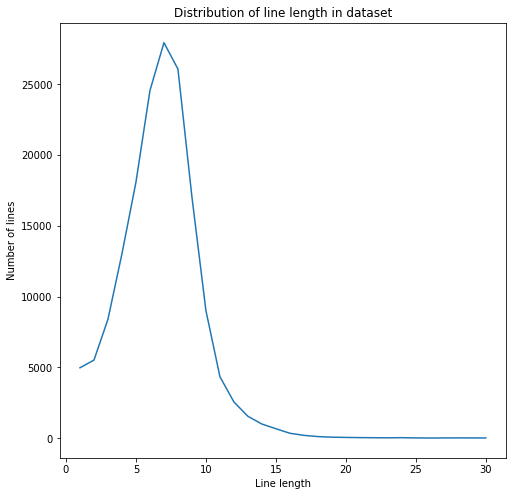

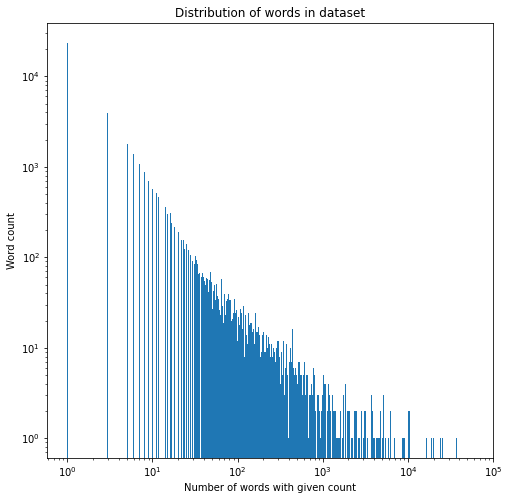

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_data = sorted(zip(line_lengths.keys(), list(line_lengths.values())), key=lambda x: x[0])
X = [x[0] for x in plot_data]
Y = [x[1] for x in plot_data]
ax.plot(X, Y)
plt.xlabel("Line length")
plt.ylabel("Number of lines")
plt.title("Distribution of line length in dataset")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plot_data = [
  x
  for x in list(word_counts.values())
  # if x > 100
]
ax.hist(
    plot_data, 
    bins=np.logspace(np.log10(min(plot_data)),np.log10(max(plot_data)), 500)
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Word count")
plt.ylabel("Number of words with given count")
plt.title("Distribution of words in dataset")
plt.show()

In [ ]:
SOS_token = 0
EOS_token = 1


class Tok:
    def __init__(self, name):
        self.name = name
        # self.word2index = {}
        self.word2index = {"SOS": SOS_token, "EOS": EOS_token}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split():
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
t_tokenizer = Tok("idk")
for pair in dataset:
  t_tokenizer.addSentence(pair[0])
  t_tokenizer.addSentence(pair[1])

In [ ]:
!wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
!unzip glove.6B.zip

In [ ]:
glove = pd.read_csv('glove.6B.100d.txt', sep=" ", quoting=3, header=None, index_col=0)
glove_embedding = {key: val.values for key, val in glove.T.items()}

word_index = t_tokenizer.word2index
dimension = 100

embedding_matrix=np.zeros((len(word_index)+1,dimension))
for word,index in word_index.items():
    if word in glove_embedding:
      embedding_matrix[index]=glove_embedding[word]
    else:
      embedding_matrix[index]=np.random.normal(scale=0.6, size=(dimension, ))

vocab_size=embedding_matrix.shape[0]
vector_size=embedding_matrix.shape[1]

embedding=nn.Embedding(num_embeddings=vocab_size,embedding_dim=vector_size)
embedding.weight=nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
embedding.weight.requires_grad=False

In [ ]:
embedding(torch.LongTensor([1]))

tensor([[-1.1851,  0.6478, -0.2503,  0.0403, -0.8263, -0.0807, -0.2397,  0.0954,
          1.1615,  0.5814, -0.0958, -0.2305,  0.1866, -1.1271, -0.4197,  0.2191,
         -0.3206,  0.6916, -1.0723, -1.3543,  0.6048, -0.4980,  0.0220, -1.1853,
          0.8162,  1.0848, -0.5538, -0.1479,  1.2835,  0.0263,  0.2002,  0.8616,
          0.0659, -1.0409,  0.7651, -0.2987,  0.5579,  0.6750, -0.1126, -0.2971,
         -0.2820, -0.6926, -0.0708,  0.5087, -0.0880, -0.0171,  0.5061,  0.7111,
          1.2538,  0.6433,  0.5380, -0.0028,  0.4764, -0.2339,  0.0292,  0.3930,
         -0.7014,  0.2457, -0.1706, -0.3737,  0.7465, -0.6025,  0.1188, -1.4595,
          0.5880, -0.1503,  1.0832,  0.9282, -0.5269, -0.9553,  0.4756, -0.9422,
         -0.3861, -0.8488, -0.3732, -1.1486, -0.0185, -0.2662,  0.4863,  0.0359,
          0.9313, -0.1165, -0.3677,  0.5302, -0.4028, -0.3753,  0.9071,  1.2371,
         -0.2545, -0.1301, -0.5088,  0.2781, -0.7636, -0.8144,  0.4945,  0.5035,
         -1.2912,  0.5619,  

In [ ]:
# Based on 
# https://github.com/pytorch/tutorials/blob/master/intermediate_source/seq2seq_translation_tutorial.py
# with our changes

pairs=dataset

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        # self.embedding = nn.Embedding(input_size, hidden_size)
        self.embedding=nn.Embedding(num_embeddings=vocab_size,embedding_dim=vector_size)
        self.embedding.weight=nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embedding.weight.requires_grad=False

        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)



class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # self.embedding = nn.Embedding(output_size, hidden_size)
        self.embedding=nn.Embedding(num_embeddings=vocab_size,embedding_dim=vector_size)
        self.embedding.weight=nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embedding.weight.requires_grad=False
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)



class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        # self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.embedding=nn.Embedding(num_embeddings=vocab_size,embedding_dim=vector_size)
        self.embedding.weight=nn.Parameter(torch.tensor(embedding_matrix,dtype=torch.float32))
        self.embedding.weight.requires_grad=False

        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)



def indexesFromSentence(lang, sentence):
  res = []
  try:
    res = [lang.word2index[word] for word in sentence.split()]
  except Exception as e:
    print(sentence)
    raise
  return res


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    res = torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)
    # print(sentence)
    # print(res)
    # input()
    return res

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(t_tokenizer, pair[0])
    target_tensor = tensorFromSentence(t_tokenizer, pair[1])
    return (input_tensor, target_tensor)



teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


def train_no_attention(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


# TODO change this to tqdm
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))



######################################################################
# The whole training process looks like this:
#
# -  Start a timer
# -  Initialize optimizers and criterion
# -  Create set of training pairs
# -  Start empty losses array for plotting
#
# Then we call ``train`` many times and occasionally print the progress (%
# of examples, time so far, estimated time) and average loss.
#

def trainIters(encoder, decoder, n_iters, use_attention, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        if use_attention:
          loss = train(input_tensor, target_tensor, encoder,
                      decoder, encoder_optimizer, decoder_optimizer, criterion)
        else:
          loss = train_no_attention(input_tensor, target_tensor, encoder,
                      decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


######################################################################
# Plotting results
# ----------------
#
# Plotting is done with matplotlib, using the array of loss values
# ``plot_losses`` saved while training.
#

import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


######################################################################
# Evaluation
# ==========
#
# Evaluation is mostly the same as training, but there are no targets so
# we simply feed the decoder's predictions back to itself for each step.
# Every time it predicts a word we add it to the output string, and if it
# predicts the EOS token we stop there. We also store the decoder's
# attention outputs for display later.
#

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(t_tokenizer, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('EOS')
                break
            else:
                decoded_words.append(t_tokenizer.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


def evaluate_no_attention(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(t_tokenizer, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('EOS')
                break
            else:
                decoded_words.append(t_tokenizer.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words


######################################################################
# We can evaluate random sentences from the training set and print out the
# input, target, and output to make some subjective quality judgements:
#

def evaluateRandomly(encoder, decoder, use_attention, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        if use_attention:
          output_words, attentions = evaluate(encoder, decoder, pair[0])
        else:
          output_words = evaluate_no_attention(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


######################################################################
# Training and Evaluating
# =======================
#
# With all these helper functions in place (it looks like extra work, but
# it makes it easier to run multiple experiments) we can actually
# initialize a network and start training.
#
# Remember that the input sentences were heavily filtered. For this small
# dataset we can use relatively small networks of 256 hidden nodes and a
# single GRU layer. After about 40 minutes on a MacBook CPU we'll get some
# reasonable results.
#
# .. Note::
#    If you run this notebook you can train, interrupt the kernel,
#    evaluate, and continue training later. Comment out the lines where the
#    encoder and decoder are initialized and run ``trainIters`` again.
#

use_attention=True
hidden_size = vector_size
encoder1 = EncoderRNN(t_tokenizer.n_words, hidden_size).to(device)
if use_attention:
  attn_decoder1 = AttnDecoderRNN(hidden_size, t_tokenizer.n_words, dropout_p=0.1).to(device)
else:
  attn_decoder1 = DecoderRNN(hidden_size, t_tokenizer.n_words).to(device)
# use_attention=True

trainIters(encoder1, attn_decoder1, 10000, print_every=1000, use_attention=use_attention)

######################################################################
#

evaluateRandomly(encoder1, attn_decoder1, use_attention=use_attention)


0m 25s (- 3m 45s) (1000 10%) 5.9477
0m 52s (- 3m 28s) (2000 20%) 6.0431
1m 19s (- 3m 4s) (3000 30%) 6.0212
1m 47s (- 2m 41s) (4000 40%) 5.8996
2m 13s (- 2m 13s) (5000 50%) 5.8143
2m 41s (- 1m 47s) (6000 60%) 5.9186
3m 8s (- 1m 20s) (7000 70%) 5.9219
3m 35s (- 0m 53s) (8000 80%) 5.7473
4m 2s (- 0m 26s) (9000 90%) 5.7862
4m 30s (- 0m 0s) (10000 100%) 5.8326
> the flowers have had a frost 
= each herb hath lost her savour 
< i the EOS

> doth straight forget the dangers of the sea 
= but i vnhappie i can neuer show 
< i the the EOS

> equal trophies of thine art 
= e en the flowing azure air
< i the EOS

> elegance
= ene rgetic
< EOS

> than the day visions of a mind unsound 
= disorder d phantasies indulged too much 
< i the the EOS

> ye tender objects of maternal love 
= ye dearest joys my widow d heart can prove 
< i the EOS

> poetasters are anonymous in every town
= and they never do know of literary renown 
< i the EOS

> thus partridge by his wit and parts
= at once did practise b

In [ ]:

# After maaany trainIters we can sometimes get more than 5 different words. We need pretrained model.... 
# Or at least place where we can run it over the night 

trainIters(encoder1, attn_decoder1, 75000, print_every=1000, use_attention=use_attention)

######################################################################
#

# evaluateRandomly(encoder1, attn_decoder1, use_attention=use_attention)
